In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import random
#import gradio
from sklearn.utils.class_weight import compute_class_weight


In [20]:
labels = ["PNEUMONIA", "NORMAL"]
img_size = 150

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
                if img_arr is None:  # Check if the image was loaded successfully
                    print(f"Failed to read image: {img_path}")
                    continue
                
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error processing {img}: {e}")
    return data
        

In [21]:
train = get_data("/kaggle/input/chest-xray-pneumonia/chest_xray/train")
test = get_data("/kaggle/input/chest-xray-pneumonia/chest_xray/test")
val = get_data("/kaggle/input/chest-xray-pneumonia/chest_xray/val")

In [22]:
data = train + val + test
print(len(data))
pneum = sum(1 for line in data if line[1] == 0)
norml = sum(1 for line in data if line[1] == 1)
print(pneum)
print(norml)
pneum - norml


5856
4273
1583


2690

In [23]:
# SPLIT DATA  TRAIN   VALIDATION   TEST

random.seed(42)
random.shuffle(data)

images = [item[0] for item in data]
labels = [item[1] for item in data]

x_train, temp_images, y_train, temp_labels = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)

x_val, x_test, y_val, y_test = train_test_split(
    temp_images, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

print(f"Train: {len(x_train)} images")
print(f"Validation: {len(x_val)} images")
print(f"Test: {len(x_test)} images")

Train: 4684 images
Validation: 586 images
Test: 586 images


In [24]:
# NORMALIZATION

x_train = np.array(x_train)/255
x_val = np.array(x_val)/255
x_test = np.array(x_test)/255

In [25]:
# RESIZING
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [26]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

In [27]:
y_train = np.array(y_train).ravel() 

In [28]:
# CLASS WEIGHTS
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}  # 0 for pneumonia, 1 for normal

print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.6851960210649503, 1: 1.8499210110584519}


In [35]:
# MODEL

model = Sequential()
model.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(img_size, img_size, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))

model.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))

model.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))

model.add(Conv2D(128, (3,3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))

model.add(Conv2D(256, (3,3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 38, 38, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 38, 38, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 19, 19, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 10, 10, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 10, 10, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6400)                │              

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [30]:
# TRAINING

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    x_train, y_train,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)

Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.8101 - loss: 1.3873 - val_accuracy: 0.7287 - val_loss: 6.9310
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.9487 - loss: 0.1455 - val_accuracy: 0.7287 - val_loss: 6.6865
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.9518 - loss: 0.1379 - val_accuracy: 0.7287 - val_loss: 2.0522
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 0.9443 - loss: 0.1390 - val_accuracy: 0.7918 - val_loss: 0.7345
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.9666 - loss: 0.0973 - val_accuracy: 0.9573 - val_loss: 0.1551
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.9627 - loss: 0.1143 - val_accuracy: 0.9403 - val_loss: 0.1421
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.9648 - loss: 0.0883 - val_accuracy: 0.9590 - val_loss: 0.0881
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.9749 - loss: 0.0692 - val_accu

In [31]:
print("loss", model.evaluate(x_test, y_test)[0])
print('accuracy', model.evaluate(x_test, y_test)[1]*100, '%')

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - accuracy: 0.9601 - loss: 0.0946
loss 0.1047634705901146
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - accuracy: 0.9601 - loss: 0.0946
accuracy 96.07508778572083 %


In [34]:
model.save('pneumonie_xray_prediction150x150 96%.h5')


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 279ms/step


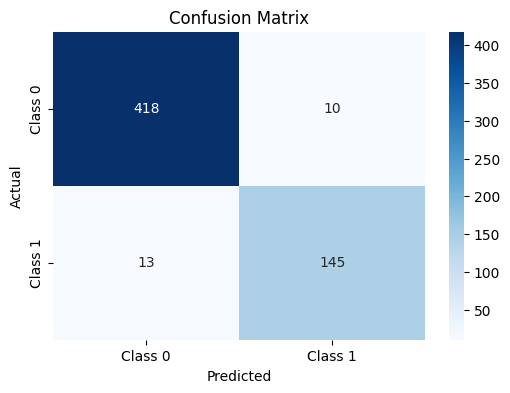

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       428
           1       0.94      0.92      0.93       158

    accuracy                           0.96       586
   macro avg       0.95      0.95      0.95       586
weighted avg       0.96      0.96      0.96       586



In [33]:
# MATRICE DE CONFUSION

y_pred_prob = model.predict(x_test)  # Probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert to binary labels (0 or 1)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred))


# PNEUMONIA --> CLASS 0
# NORMAL    --> CLASS 1